In [83]:
import pandas as pd
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('X_train.csv')
df_test=pd.read_csv('X_test.csv')
df_test.columns

In [ ]:
categorical_features=[feature for feature in df.columns if df[feature].dtype=='O']
categorical_features

In [ ]:
df[categorical_features].nunique()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


163000.0

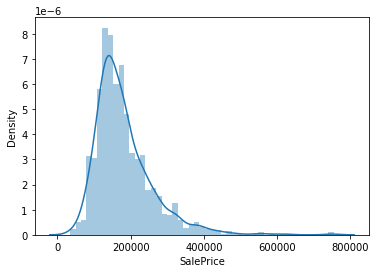

In [87]:
sns.distplot(df['SalePrice'])
np.median(df['SalePrice'])

In [88]:
from catboost import CatBoost, CatBoostRegressor, Pool

In [89]:
data=df.copy().sample(frac=1,random_state=1)
data_train=data.iloc[:2*len(df)//3]
data_test=data.iloc[2*len(df)//3:]
trainPool= Pool(data_train.drop(['SalePrice'],1),cat_features=categorical_features,label=data_train.SalePrice)
testPool= Pool(data_test.drop(['SalePrice'],1),cat_features=categorical_features,label=data_test.SalePrice)

In [92]:
model=CatBoostRegressor(custom_metric=['R2','RMSE'],learning_rate=0.1,n_estimators=5000)

In [93]:
model.fit(trainPool,eval_set=testPool,verbose=1000,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76018.4492979	test: 72754.4534565	best: 72754.4534565 (0)	total: 60.8ms	remaining: 5m 3s
1000:	learn: 3410.1251201	test: 24395.6450935	best: 24362.0977132 (715)	total: 31.7s	remaining: 2m 6s
2000:	learn: 1137.5264868	test: 24330.5561892	best: 24324.2658996 (1759)	total: 1m 6s	remaining: 1m 39s
3000:	learn: 456.2636773	test: 24302.4489750	best: 24302.4489750 (3000)	total: 1m 43s	remaining: 1m 8s
4000:	learn: 215.5767929	test: 24301.6012999	best: 24298.3071987 (3386)	total: 2m 23s	remaining: 35.9s
4999:	learn: 109.9149069	test: 24298.9977892	best: 24298.3071987 (3386)	total: 3m 8s	remaining: 0us

bestTest = 24298.3072
bestIteration = 3386

Shrink model to first 3387 iterations.


**Applying Catboost and kfold to get best model with different parameters. Because there are many categorical features, we can use catboost to find best model with best parameters.**

In [112]:
kf=KFold(n_splits=3,shuffle=True)
Default_Params={'n_estimators':3390,'learning_rate':0.1}
Default_model_metrics={}

def score_catboost_model(catboost_params,update_defaults=False):
  r2_values=[]
  rmse_values=[]
  catboost_params.update(Default_Params)
  for train_index,test_index in kf.split(df):
    trainPool= Pool(df.iloc[train_index].drop(['SalePrice','Id'],1),cat_features=categorical_features,label=df.iloc[train_index].SalePrice)
    testPool= Pool(df.iloc[test_index].drop(['SalePrice','Id'],1),cat_features=categorical_features,label=df.iloc[test_index].SalePrice)
    model=CatBoost(catboost_params)
    model.fit(trainPool,verbose=False)

    r2_values.append(r2_score(df.iloc[test_index].SalePrice.values,model.predict(testPool)))
    rmse_values.append(mean_squared_error(df.iloc[test_index].SalePrice.values,model.predict(testPool),squared=False))

  if update_defaults:
    Default_model_metrics['R2']=np.mean(r2_values)
    Default_model_metrics['RMSE']=np.mean(rmse_values)
    print('R2 Score: '+str(np.mean(r2_values))+'('+str(np.std(r2_values))+')')
    print('RMSE Score: '+str(np.mean(rmse_values))+'('+str(np.std(rmse_values))+')')
  else:
    Default_model_R2=Default_model_metrics['R2']
    Default_model_RMSE=Default_model_metrics['RMSE']
    r2change=100*(np.mean(r2_values)-Default_model_R2)/Default_model_R2
    rmsechange=100*(np.mean(rmse_values)-Default_model_RMSE)/Default_model_RMSE
    print('R2 score: {:.4f}({:.4f}) {:+.1f}% compared to default parameters'.format(np.mean(r2_values), np.std(r2_values), r2change))
    print('RMSE score: {:.0f}({:.0f}) {:+.1f}% compared to default parameters'.format(np.mean(rmse_values), np.std(rmse_values), rmsechange)) 

  return model.get_all_params()

In [114]:
last_model_params = score_catboost_model({}, True)

R2 Score: 0.8696650225983261(0.04128669409969643)
RMSE Score: 28237.962992398312(4228.416835468251)


We have used catboost with different params i.e. we told our model to use one hot encoding on our model and train and test it.
We gave one hot encoding max size as 25 as the feature **Neighborhood** in our dataset has 23 categories.

In [115]:
model_params_one_hot=score_catboost_model({'one_hot_max_size':25})

R2 score: 0.8633(0.0432) -0.7% compared to default parameters
RMSE score: 28910(4546) +2.4% compared to default parameters


Let us try to set model size regularization coefficient to 0 — thus we allow our model to use as many categorical features and its combinations as it wants.

In [116]:
model_params = score_catboost_model({'model_size_reg': 0})

R2 score: 0.8897(0.0177) +2.3% compared to default parameters
RMSE score: 26133(998) -7.5% compared to default parameters


In [119]:
model_params = score_catboost_model({'max_ctr_complexity': 6,'model_size_reg': 0})

R2 score: 0.8992(0.0132) +3.4% compared to default parameters
RMSE score: 25133(1408) -11.0% compared to default parameters


In [66]:
model_params_size_1 = score_catboost_model({'model_size_reg': 1})

R2 score: 0.8905(0.0229) -0.9% compared to default parameters
RMSE score: 0(0) +3.4% compared to default parameters


In [120]:
catboost_params={'n_estimators':3390,'learning_rate':0.1,'max_ctr_complexity': 6,'model_size_reg': 0}
trainPool= Pool(df.drop(['SalePrice','Id'],1),cat_features=categorical_features,label=df['SalePrice'])
model=CatBoost(catboost_params)

In [121]:
model.fit(trainPool,verbose=False)

In [122]:
testPool= Pool(df_test.drop(['Id'],1),cat_features=categorical_features,label=df_test['Id'])

In [123]:
x=model.predict(testPool)

In [106]:
2919-1461-487

971

In [136]:
output=pd.DataFrame(data=x,columns=['SalePrice'],index=df_test['Id'])


In [140]:
output.to_csv('trial.csv',index=True)